# Data Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

sns.set_theme(style='darkgrid')

In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
# change root to the necessary path
root = "/gdrive/MyDrive/ads_proj4/ads-spring-2022-prj4-group-11-1/"
outputs_dir = root + "output/"

In [4]:
assert os.path.exists(root), 'Check the path to your root directory'
assert os.path.exists(outputs_dir), 'Check the path to your outputs directory'

In [5]:
data = pd.read_csv(outputs_dir + 'ffs_data_v3.csv', header=0,
                     dtype = {'age_cat': int,'race': int,
                              'priors_count': int,'length_of_stay': int})

In [6]:
dummy_data = data.copy()
dummy_data['sex'] = (dummy_data['sex'].values == 'Male').astype(int) # 1 if male, 0 if female
dummy_data['c_charge_degree'] = (dummy_data['c_charge_degree'].values == 'F').astype(int) # 1 if felony, 0 if misdemeanor
dummy_data[['age', 'race', 'priors_count', 'length_of_stay']] = dummy_data[['age', 'race', 'priors_count', 'length_of_stay']].astype(int)

juv_cond = (dummy_data['juv_fel_count'] > 0) | (dummy_data['juv_misd_count'] > 0) | (dummy_data['juv_other_count'] > 0)
dummy_data['has_juv'] = np.where(juv_cond, 1, 0)
dummy_data['has_prior'] = np.where(dummy_data['priors_count'] > 0, 1, 0)
#race[0:African-American,1:Caucasian]
dummy_data.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,has_juv,has_prior
0,34,1,0,1,0,1,1,0,0,0,0,0
1,24,1,0,1,2,0,1,0,0,1,1,1
2,41,1,1,1,2,0,1,0,0,0,0,1
3,39,0,1,0,0,0,0,0,0,0,0,0
4,27,1,1,1,0,0,0,0,0,0,0,0


In [7]:
X = dummy_data[['age', 'c_charge_degree', 'sex', 'race', 'length_of_stay', 'has_juv', 'has_prior']]
y = dummy_data['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

train_df = pd.concat([X_train, y_train], axis = 1)

# Model Training

In [8]:
GBC = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
clf = GBC.fit(X_train, y_train);

In [9]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       559
           1       0.64      0.62      0.63       497

    accuracy                           0.66      1056
   macro avg       0.66      0.66      0.66      1056
weighted avg       0.66      0.66      0.66      1056



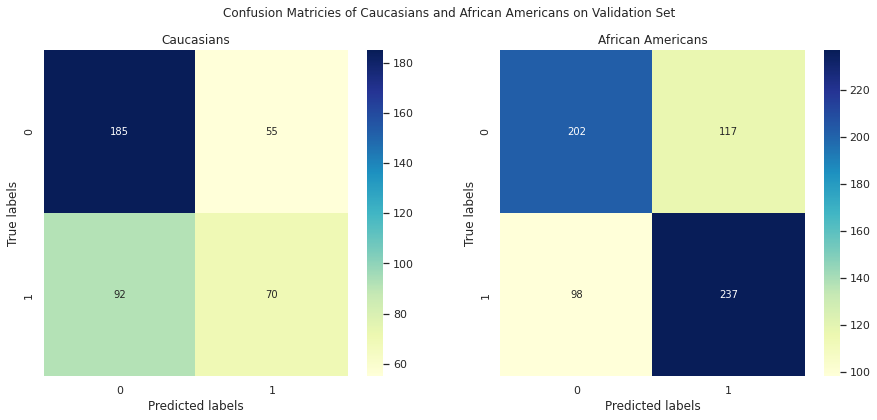

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Confusion Matricies of Caucasians and African Americans on Validation Set')

y_test_pred_c = clf.predict(X_test[X_test['race']==1])
cm_c = confusion_matrix(y_test[X_test['race']==1], y_test_pred_c)
sns.heatmap(cm_c, annot=True, fmt='g', ax=ax[0], cmap="YlGnBu")
ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('True labels')
ax[0].set_title('Caucasians')

y_test_pred_aa = clf.predict(X_test[X_test['race']==0])
cm_aa = confusion_matrix(y_test[X_test['race']==0], y_test_pred_aa)
sns.heatmap(cm_aa, annot=True, fmt='g', ax=ax[1], cmap="YlGnBu")
ax[1].set_xlabel('Predicted labels');ax[1].set_ylabel('True labels')
ax[1].set_title('African Americans');

In [11]:
summary_stats = []

def model_score(y_true, y_pred):
    stats=[]
   
    Pre = precision_score(y_true, y_pred)
    Rec = recall_score(y_true, y_pred)
    Acc = accuracy_score(y_true, y_pred)
    stats.extend([Pre,Rec,Acc])

    return stats

y_train_pred = clf.predict(X_train)

summary_stats.extend(model_score(y_train, y_train_pred))
summary_stats.extend(model_score(y_test, y_test_pred))

## Model evaluation on 3 fairness definitions - Parity, Calibration, and Equality of Odds

In [12]:
y_test_pred_c = clf.predict(X_test[X_test['race']==1])
tn_c, fp_c, fn_c, tp_c  = confusion_matrix(y_test[X_test['race']==1], y_test_pred_c).ravel()
y_test_pred_aa = clf.predict(X_test[X_test['race']==0])
tn_aa, fp_aa, fn_aa, tp_aa = confusion_matrix(y_test[X_test['race']==0], y_test_pred_aa).ravel()

### Parity

In [13]:
C = tp_c/(tn_c+fp_c+fn_c+tp_c)
AA = tp_aa/(tn_aa+fp_aa+fn_aa+tp_aa)
print('P(G=1|Race=Caucasian)=', C)
print('P(G=1|Race=African American)=', AA)
print('P(G=1|Race=African American)!=P(G=1|Race=Caucasian)')
print('Parity:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=1|Race=Caucasian)= 0.17412935323383086
P(G=1|Race=African American)= 0.3623853211009174
P(G=1|Race=African American)!=P(G=1|Race=Caucasian)
Parity: 0.18825596786708657


### Calibration

In [14]:
C = (tn_c+tp_c)/(tn_c+fp_c+fn_c+tp_c)
AA = (tn_aa+tp_aa)/(tn_aa+fp_aa+fn_aa+tp_aa)
print('P(G=T|Race=Caucasian)=', C)
print('P(G=T|Race=African American)=', AA)
print('P(G=T|Race=African American)~=P(G=T|Race=Caucasian)')
print('Calibration:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=T|Race=Caucasian)= 0.6343283582089553
P(G=T|Race=African American)= 0.6712538226299695
P(G=T|Race=African American)~=P(G=T|Race=Caucasian)
Calibration: 0.03692546442101419


### Equality of Odds:

In [15]:
C = (tp_c)/(fn_c+tp_c)
AA = (tp_aa)/(fn_aa+tp_aa)
print('P(G=T|Race=Caucasian,Recidivism=True)=', C)
print('P(G=T|Race=African American,Recidivism=True)=', AA)
print('P(G=T|Race=African American,Recidivism=True)!=P(G=T|Race=caucasian,Recidivism=True)')
print('Equality of Odds:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=T|Race=Caucasian,Recidivism=True)= 0.43209876543209874
P(G=T|Race=African American,Recidivism=True)= 0.7074626865671642
P(G=T|Race=African American,Recidivism=True)!=P(G=T|Race=caucasian,Recidivism=True)
Equality of Odds: 0.2753639211350654


### False Positive Rate (5-folder cross validation)

In [16]:
def FPR(fp, tn):
  return fp / (fp + tn)

def bias_exp(X, y, exp_num=5, algor=''):
  FPR_black = []
  FPR_white = []
  Acc = []

  for i in range(exp_num):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i*5)
    # X_train = X_train.drop('race', axis=1)
    model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
    if algor == '':
      modified_train = pd.concat([X_train, y_train], axis = 1)
    elif algor == 'LM': 
      modified_train = LM(pd.concat([X_train, y_train], axis = 1)).drop(['rank'], axis=1)
    elif algor == 'LPS':
      modified_train = LPS(pd.concat([X_train, y_train], axis = 1)).drop(['rank'], axis=1)
    model.fit(modified_train.drop(['two_year_recid'], axis=1), modified_train['two_year_recid'])

    # accuracy
    y_pred = model.predict(X_test)
    ac = accuracy_score(y_test, y_pred)
    Acc.append(ac)

    data = X_test.assign(two_year_recid = y_test)
    data_black = data[data['race']==0]
    data_white = data[data['race']==1]

    y_pred_black = model.predict(data_black.drop(['two_year_recid'], axis=1))
    y_pred_white = model.predict(data_white.drop(['two_year_recid'], axis=1))

    # black
    tn, fp, fn, tp = confusion_matrix(data_black['two_year_recid'], 
                                      y_pred_black).ravel()
    black_fpr = FPR(fp, tn)
    FPR_black.append(black_fpr)
    # white
    tn, fp, fn, tp = confusion_matrix(data_white['two_year_recid'], 
                                      y_pred_white).ravel()
    white_fpr = FPR(fp, tn)
    FPR_white.append(white_fpr)

  return FPR_black, FPR_white, Acc

In [17]:
X = dummy_data[['age', 'race', 'c_charge_degree', 'sex', 'length_of_stay', 'has_juv', 'has_prior']]
y = dummy_data['two_year_recid']

model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
exp_df_Ori = pd.DataFrame(columns=['Experiment', 'Accuracy (mean)', 'Accuracy (std)', 
                               'Black FPR', 'White FPR'])

black_fpr, white_fpr, Acc = bias_exp(X, y)
exp_df_Ori.loc[len(exp_df_Ori.index)] = ["Original", np.mean(Acc), np.std(Acc),
                                 np.mean(black_fpr), np.mean(white_fpr)]

exp_df_Ori

,Experiment,Accuracy (mean),Accuracy (std),Black FPR,White FPR
0,Original,0.667614,0.018778,0.396039,0.185077


# A6 Algorithms--Handling Conditional Discrimination (LM and LPS)

## Measure of Discrimination

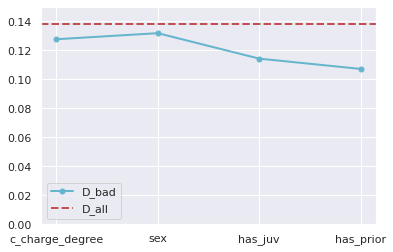

In [18]:
bad_dis = []
overview = []
overall_AA = train_df[train_df.race == 0].two_year_recid.sum()/train_df[train_df.race == 0].shape[0]
overall_Caucasian = train_df[train_df.race == 1].two_year_recid.sum()/train_df[train_df.race == 1].shape[0]
features = ['c_charge_degree', 'sex', 'has_juv', 'has_prior']
for feature in features:
  df = train_df.groupby([feature, 'race']).two_year_recid.agg(['count','sum']).reset_index()
  df['recid_rate'] = df['sum']/df['count']
  df['corrected_recid_rate'] = 0
  df.loc[df[feature] == 1, 'corrected_recid_rate'] = df.groupby(feature).recid_rate.mean()[1]
  df.loc[df[feature] == 0, 'corrected_recid_rate'] = df.groupby(feature).recid_rate.mean()[0]
  df['corrected_recid_count'] = round(df['count'] * df['corrected_recid_rate']).astype(int)
  overview.append(df)
  D_expl = df[df.race == 0].corrected_recid_count.sum()/train_df[train_df.race == 0].shape[0] - df[df.race == 1].corrected_recid_count.sum()/train_df[train_df.race == 1].shape[0]
  bad_dis.append(((overall_AA-overall_Caucasian) - D_expl))

from matplotlib.legend_handler import HandlerLine2D
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(features, bad_dis, 'c.-', linewidth=2, markersize=10, label='D_bad')
plt.axhline(y=(overall_AA-overall_Caucasian), c="r", ls="--", lw=2, label='D_all')
handles, _ = ax.get_legend_handles_labels()
labels = ["D_bad", "D_all"]
plt.legend(handles = handles, labels = labels)
plt.ylim((0, 0.15))
plt.show();

In [19]:
pre_overview = overview[-1]
pre_overview.loc[pre_overview['race'] == 1, 'race'] = 'Caucasian'
pre_overview.loc[pre_overview['race'] == 0, 'race'] = 'African-American'
pre_overview.loc[pre_overview['has_prior'] == 1, 'has_prior'] = 'True'
pre_overview.loc[pre_overview['has_prior'] ==0, 'has_prior'] = 'False'
pre_overview.rename(columns={'sum':'recid_count'}, inplace=True)
pre_overview

,has_prior,race,count,recid_count,recid_rate,corrected_recid_rate,corrected_recid_count
0,False,African-American,667,230,0.344828,0.300752,201
1,False,Caucasian,674,173,0.256677,0.300752,203
2,True,African-American,1854,1096,0.591154,0.532675,988
3,True,Caucasian,1027,487,0.474197,0.532675,547


In [20]:
overall_AA = train_df[train_df.race == 0].two_year_recid.sum()/train_df[train_df.race == 0].shape[0]
overall_Caucasian = train_df[train_df.race == 1].two_year_recid.sum()/train_df[train_df.race == 1].shape[0]
D_expl = pre_overview[pre_overview.race == 'African-American'].corrected_recid_count.sum()/train_df[train_df.race == 0].shape[0] - pre_overview[pre_overview.race == 'Caucasian'].corrected_recid_count.sum()/train_df[train_df.race == 1].shape[0]

print(f'the overall difference in training dataset: {(overall_AA-overall_Caucasian)*100:0.2f}%')
print(f'the difference can be objective explainable by has_prior in training dataset: {D_expl*100:0.2f}%')
print(f'the bad discrimination in training dataset: {((overall_AA-overall_Caucasian) - D_expl)*100:0.2f}%')

the overall difference in training dataset: 13.80%
the difference can be objective explainable by has_prior in training dataset: 3.07%
the bad discrimination in training dataset: 10.73%


## LM algorithm

In [21]:
RACE = "race"
DEGREE = "has_prior"
TWO_YEAR_RECID = "two_year_recid"

def PARTITION(full_df, e):
    ret_dfs = list()
    uniques = np.unique(e)
    
    for u in uniques:
        ret_dfs.append(full_df[full_df[DEGREE]==u])
    
    return ret_dfs
    
#full_dfi is the dataframe with all columns, but partitioned to one crime degree
#si is the current sensitive parameter value
def DELTA(full_df, full_dfi, si):
    
    raceSub1 = full_dfi[RACE]==si
    Gi = sum(raceSub1)
    
    num1 = sum(full_dfi[raceSub1][TWO_YEAR_RECID]==1)
    denom1 = len(full_dfi[raceSub1])
    P1 = num1/denom1
    
    raceSub2 = full_dfi[RACE]!=si
    num2 = sum(full_dfi[raceSub2][TWO_YEAR_RECID]==1)
    denom2 = len(full_dfi[raceSub2])
    P2 = num2/denom2  
      
    Ps = 0.5*(P1 + P2)

    return np.floor(Gi*abs(P1-Ps)).astype(np.int64)

In [22]:
def LM(train_df):
  LM_parts = []
  for part in PARTITION(train_df, train_df[DEGREE]):
      #train the model
      X_part = part.drop(TWO_YEAR_RECID, axis=1)
      y_part = part[TWO_YEAR_RECID]
      model = GBC.fit(X_part, y_part)
      
      #RACE=1: Caucasian
      part1 = part[part[RACE]==1]
      part1.reset_index(drop=True, inplace=True)
      delta1 = DELTA(train_df, part, 1)
      X_part1 = part1.drop(TWO_YEAR_RECID, axis=1)
      y_part1 = part1[TWO_YEAR_RECID]
      rank = pd.DataFrame(model.decision_function(X_part1), columns = ['rank'])
      comb1 = pd.concat([part1, rank], axis=1)

      #RACE=0: African-American
      part0 = part[part[RACE]==0]
      part0.reset_index(drop=True, inplace=True)
      delta0 = DELTA(train_df, part, 0)
      X_part0 = part0.drop(TWO_YEAR_RECID, axis=1)
      y_part0 = part0[TWO_YEAR_RECID]
      rank = pd.DataFrame(model.decision_function(X_part0), columns = ['rank'])
      comb0 = pd.concat([part0, rank], axis=1)

      #relabel closest delta datapoints from - to + based on rank for C datapoints
      #comb1 = comb1.sort_values(['rank'])
      comb1 = comb1.sort_values([TWO_YEAR_RECID, 'rank'])
      comb1.reset_index(drop=True, inplace=True)
      
      #t = sum(comb1['rank']<0)
      t = sum(comb1[TWO_YEAR_RECID]==0)
      l = len(comb1)
      
      F1 = np.full(t-delta1, False)
      T = np.full(delta1, True)
      F2 = np.full(l-t, False)

      flip = np.concatenate([F1, T, F2])
      comb1.loc[flip, TWO_YEAR_RECID] = 1
      LM_parts.append(comb1)
      
      #relabel closest delta datapoints from + to - based on rank for AA datapoints
      # comb0 = comb0.sort_values(['rank'])
      comb0 = comb0.sort_values([TWO_YEAR_RECID, 'rank'])
      comb0.reset_index(drop=True, inplace=True)
      
      # t = sum(comb0['rank']>0)
      t = sum(comb0[TWO_YEAR_RECID]==1)
      l = len(comb0)
      
      F1 = np.full(l-t, False)
      T = np.full(delta0, True)
      F2 = np.full(t-delta0, False)

      flip = np.concatenate([F1, T, F2])
      comb0.loc[flip, TWO_YEAR_RECID] = 0
      LM_parts.append(comb0)

  train_df_lm = pd.concat([LM_parts[0],LM_parts[1], LM_parts[2], LM_parts[3]], axis=0)

  return train_df_lm

### Measure of Discrimination——After LM

In [23]:
train_df_lm = LM(train_df)

after_overview = train_df_lm.groupby([DEGREE, 'race']).two_year_recid.agg(['count','sum']).reset_index()
after_overview['recid_rate'] = after_overview['sum']/after_overview['count']
after_overview.loc[after_overview['race'] == 1, 'race'] = 'Caucasian'
after_overview.loc[after_overview['race'] == 0, 'race'] = 'African-American'
after_overview.loc[after_overview['has_prior'] == 1, 'has_prior'] = 'True'
after_overview.loc[after_overview['has_prior'] ==0, 'has_prior'] = 'False'
after_overview.rename(columns={'sum':'recid_count'}, inplace=True)
after_overview

,has_prior,race,count,recid_count,recid_rate
0,False,African-American,667,201,0.301349
1,False,Caucasian,674,202,0.299703
2,True,African-American,1854,988,0.532902
3,True,Caucasian,1027,547,0.532619


### Model evaluation--After LM

In [24]:
GBC = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
clf_lm = GBC.fit(train_df_lm.drop(['two_year_recid', 'rank'], axis=1), train_df_lm['two_year_recid']);

In [25]:
y_test_pred_lm = clf_lm.predict(X_test)
print(classification_report(y_test, y_test_pred_lm))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       559
           1       0.65      0.59      0.62       497

    accuracy                           0.66      1056
   macro avg       0.66      0.65      0.65      1056
weighted avg       0.66      0.66      0.66      1056



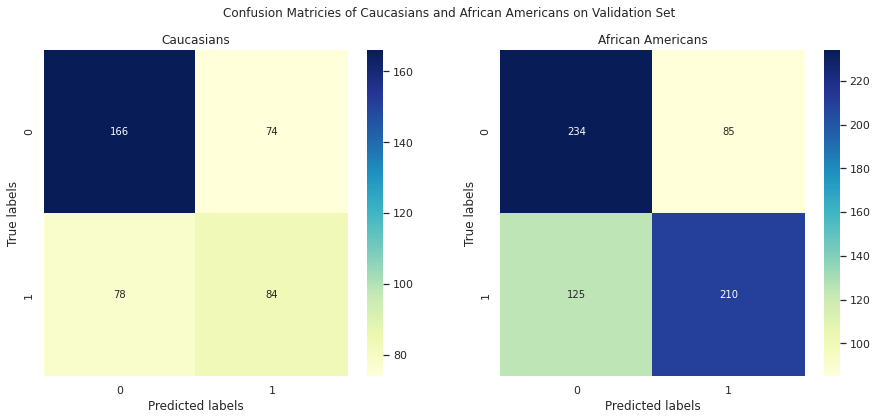

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Confusion Matricies of Caucasians and African Americans on Validation Set')

y_test_pred_c = clf_lm.predict(X_test[X_test['race']==1])
cm_c = confusion_matrix(y_test[X_test['race']==1], y_test_pred_c)
sns.heatmap(cm_c, annot=True, fmt='g', ax=ax[0], cmap="YlGnBu")
ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('True labels')
ax[0].set_title('Caucasians')

y_test_pred_aa = clf_lm.predict(X_test[X_test['race']==0])
cm_aa = confusion_matrix(y_test[X_test['race']==0], y_test_pred_aa)
sns.heatmap(cm_aa, annot=True, fmt='g', ax=ax[1], cmap="YlGnBu")
ax[1].set_xlabel('Predicted labels');ax[1].set_ylabel('True labels')
ax[1].set_title('African Americans');

In [27]:
y_train_pred_lm = clf_lm.predict(X_train)
y_test_pred_lm = clf_lm.predict(X_test)

summary_stats.extend(model_score(y_train, y_train_pred_lm))
summary_stats.extend(model_score(y_test, y_test_pred_lm))

#### parity

In [28]:
y_test_pred_c_lm = clf_lm.predict(X_test[X_test['race']==1])
tn_c, fp_c, fn_c, tp_c = confusion_matrix(y_test[X_test['race']==1], y_test_pred_c_lm).ravel()
y_test_pred_aa_lm = clf_lm.predict(X_test[X_test['race']==0])
tn_aa, fp_aa, fn_aa, tp_aa = confusion_matrix(y_test[X_test['race']==0], y_test_pred_aa_lm).ravel()

In [29]:
C = tp_c/(tn_c+fp_c+fn_c+tp_c)
AA = tp_aa/(tn_aa+fp_aa+fn_aa+tp_aa)
print('P(G=1|Race=Caucasian)=', C)
print('P(G=1|Race=African American)=', AA)
print('P(G=1|Race=African American)!=P(G=1|Race=Caucasian)')
print('Parity:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=1|Race=Caucasian)= 0.208955223880597
P(G=1|Race=African American)= 0.3211009174311927
P(G=1|Race=African American)!=P(G=1|Race=Caucasian)
Parity: 0.11214569355059567


#### Calibration

In [30]:
C = (tn_c+tp_c)/(tn_c+fp_c+fn_c+tp_c)
AA = (tn_aa+tp_aa)/(tn_aa+fp_aa+fn_aa+tp_aa)
print('P(G=T|Race=Caucasian)=', C)
print('P(G=T|Race=African American)=', AA)
print('P(G=T|Race=African American)~=P(G=T|Race=Caucasian)')
print('Calibration:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=T|Race=Caucasian)= 0.6218905472636815
P(G=T|Race=African American)= 0.6788990825688074
P(G=T|Race=African American)~=P(G=T|Race=Caucasian)
Calibration: 0.05700853530512584


#### Equality of Odds:

In [31]:
C = (tp_c)/(fn_c+tp_c)
AA = (tp_aa)/(fn_aa+tp_aa)
print('P(G=T|Race=Caucasian,Recidivism=True)=', C)
print('P(G=T|Race=African American,Recidivism=True)=', AA)
print('P(G=T|Race=African American,Recidivism=True)!=P(G=T|Race=caucasian,Recidivism=True)')
print('Equality of Odds:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=T|Race=Caucasian,Recidivism=True)= 0.5185185185185185
P(G=T|Race=African American,Recidivism=True)= 0.6268656716417911
P(G=T|Race=African American,Recidivism=True)!=P(G=T|Race=caucasian,Recidivism=True)
Equality of Odds: 0.10834715312327259


#### False Positive Rate(5-folder cross validation)

In [32]:
X = dummy_data[['age', 'race', 'c_charge_degree', 'sex', 'length_of_stay', 'has_juv', 'has_prior']]
y = dummy_data['two_year_recid']

model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
exp_df_LM = pd.DataFrame(columns=['Experiment', 'Accuracy (mean)', 'Accuracy (std)', 
                               'Black FPR', 'White FPR'])

black_fpr, white_fpr, Acc = bias_exp(X, y, algor='LM')
exp_df_LM.loc[len(exp_df_LM.index)] = ["LM", np.mean(Acc), np.std(Acc),
                                 np.mean(black_fpr), np.mean(white_fpr)]

exp_df_LM

,Experiment,Accuracy (mean),Accuracy (std),Black FPR,White FPR
0,LM,0.660038,0.011253,0.288819,0.272368


## LPS algorithm

In [33]:
def LPS(train_df):
  LPS_parts = []
  for part in PARTITION(train_df, train_df[DEGREE]):
      #train the model
      X_part = part.drop(TWO_YEAR_RECID, axis=1)
      y_part = part[TWO_YEAR_RECID]
      model = GBC.fit(X_part, y_part)

      #RACE=1: Caucasian
      part1 = part[part[RACE]==1]
      part1.reset_index(drop=True, inplace=True)
      delta1 = DELTA(train_df, part, 1)
      X_part1 = part1.drop(TWO_YEAR_RECID, axis=1)
      y_part1 = part1[TWO_YEAR_RECID]
      rank = pd.DataFrame(model.decision_function(X_part1), columns = ['rank'])
      comb1 = pd.concat([part1, rank], axis=1)

      #RACE=0: African-American
      part0 = part[part[RACE]==0]
      part0.reset_index(drop=True, inplace=True)
      delta0 = DELTA(train_df, part, 0)
      X_part0 = part0.drop(TWO_YEAR_RECID, axis=1)
      y_part0 = part0[TWO_YEAR_RECID]
      rank = pd.DataFrame(model.decision_function(X_part0), columns = ['rank'])
      comb0 = pd.concat([part0, rank], axis=1)

      #delete half of closest delta datapoints - based on rank for Caucasian datapoints
      #rank data first
      comb1 = comb1.sort_values([TWO_YEAR_RECID, 'rank'])
      comb1.reset_index(drop=True, inplace=True)

      t = sum(comb1[TWO_YEAR_RECID]==0)
      l = len(comb1)

      F1 = np.full(t-delta1, False)
      T = np.full(delta1, True)
      F2 = np.full(l-t, False)

      delete = np.invert(np.concatenate([F1, T, F2]))
  

      #duplicate half of closest dalta datapoints + based on rank for Caucasian datapoints
      F3 = np.full(t, False)
      F4 = np.full(l-t-delta1, False)

      duplicate = np.concatenate([F3, T, F4])
      
      dupes = comb1[duplicate]
      comb1 = comb1[delete]
      comb1 = pd.concat([comb1,dupes], axis=0)
      LPS_parts.append(comb1)

      #delete half of closest delta datapoints + based on rank for African American datapoints
      #rank data first
      comb0 = comb0.sort_values([TWO_YEAR_RECID, 'rank'])
      comb0.reset_index(drop=True, inplace=True)
      
      t = sum(comb0[TWO_YEAR_RECID]==1)
      l = len(comb0)

      F1 = np.full(l-t, False)
      T = np.full(delta0, True)
      F2 = np.full(t-delta0, False)

      delete = np.invert(np.concatenate([F1, T, F2]))

      #duplicate half of closest delta datapoints + based on rank for African American datapoints
      F3 = np.full(l-t-delta0, False)
      F4 = np.full(t, False)

      duplicate = np.concatenate([F3, T, F4])

      dupes = comb0[duplicate]
      comb0 = comb0[delete]
      comb0 = pd.concat([comb0,dupes], axis=0)
      LPS_parts.append(comb0)

  train_df_lps = pd.concat([LPS_parts[0],LPS_parts[1], LPS_parts[2], LPS_parts[3]], axis=0)

  return train_df_lps

### Measure of Discrimination——After LPS

In [34]:
train_df_lps = LPS(train_df)

after_overview = train_df_lps.groupby([DEGREE, 'race']).two_year_recid.agg(['count','sum']).reset_index()
after_overview['recid_rate'] = after_overview['sum']/after_overview['count']
after_overview.loc[after_overview['race'] == 1, 'race'] = 'Caucasian'
after_overview.loc[after_overview['race'] == 0, 'race'] = 'African-American'
after_overview.loc[after_overview['has_prior'] == 1, 'has_prior'] = 'True'
after_overview.loc[after_overview['has_prior'] ==0, 'has_prior'] = 'False'
after_overview.rename(columns={'sum':'recid_count'}, inplace=True)
after_overview

,has_prior,race,count,recid_count,recid_rate
0,False,African-American,667,201,0.301349
1,False,Caucasian,674,202,0.299703
2,True,African-American,1854,988,0.532902
3,True,Caucasian,1027,547,0.532619


In [35]:
GBC = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
clf_lps = GBC.fit(train_df_lps.drop(['two_year_recid', 'rank'], axis=1), train_df_lm['two_year_recid']);

In [36]:
y_test_pred_lps = clf_lps.predict(X_test)
print(classification_report(y_test, y_test_pred_lps))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       559
           1       0.66      0.52      0.58       497

    accuracy                           0.65      1056
   macro avg       0.65      0.64      0.64      1056
weighted avg       0.65      0.65      0.64      1056



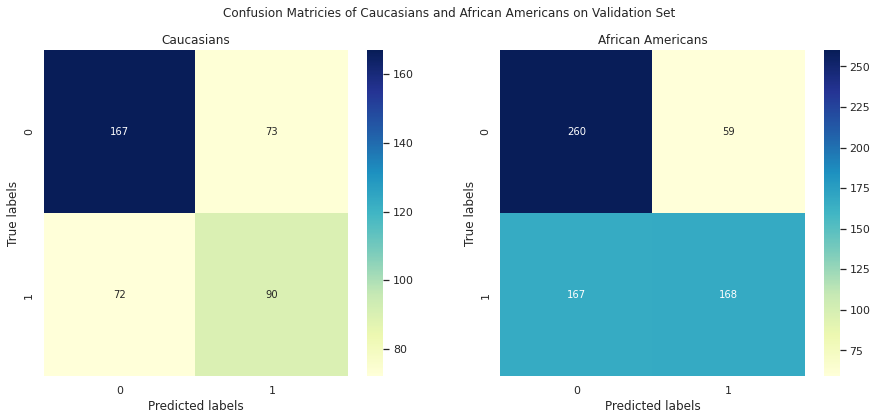

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Confusion Matricies of Caucasians and African Americans on Validation Set')

y_test_pred_c = clf_lps.predict(X_test[X_test['race']==1])
cm_c = confusion_matrix(y_test[X_test['race']==1], y_test_pred_c)
sns.heatmap(cm_c, annot=True, fmt='g', ax=ax[0], cmap="YlGnBu")
ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('True labels')
ax[0].set_title('Caucasians')

y_test_pred_aa = clf_lps.predict(X_test[X_test['race']==0])
cm_aa = confusion_matrix(y_test[X_test['race']==0], y_test_pred_aa)
sns.heatmap(cm_aa, annot=True, fmt='g', ax=ax[1], cmap="YlGnBu")
ax[1].set_xlabel('Predicted labels');ax[1].set_ylabel('True labels')
ax[1].set_title('African Americans');

In [38]:
y_train_pred_lps = clf_lps.predict(X_train)
y_test_pred_lps = clf_lps.predict(X_test)

summary_stats.extend(model_score(y_train, y_train_pred_lps))
summary_stats.extend(model_score(y_test, y_test_pred_lps))

#### parity

In [39]:
y_test_pred_c_lps = clf_lps.predict(X_test[X_test['race']==1])
tn_c, fp_c, fn_c, tp_c = confusion_matrix(y_test[X_test['race']==1], y_test_pred_c_lps).ravel()
y_test_pred_aa_lps = clf_lps.predict(X_test[X_test['race']==0])
tn_aa, fp_aa, fn_aa, tp_aa = confusion_matrix(y_test[X_test['race']==0], y_test_pred_aa_lps).ravel()

In [40]:
C = tp_c/(tn_c+fp_c+fn_c+tp_c)
AA = tp_aa/(tn_aa+fp_aa+fn_aa+tp_aa)
print('P(G=1|Race=Caucasian)=', C)
print('P(G=1|Race=African American)=', AA)
print('P(G=1|Race=African American)!=P(G=1|Race=Caucasian)')
print('Parity:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=1|Race=Caucasian)= 0.22388059701492538
P(G=1|Race=African American)= 0.25688073394495414
P(G=1|Race=African American)!=P(G=1|Race=Caucasian)
Parity: 0.03300013693002876


#### Calibration

In [41]:
C = (tn_c+tp_c)/(tn_c+fp_c+fn_c+tp_c)
AA = (tn_aa+tp_aa)/(tn_aa+fp_aa+fn_aa+tp_aa)
print('P(G=T|Race=Caucasian)=', C)
print('P(G=T|Race=African American)=', AA)
print('P(G=T|Race=African American)~=P(G=T|Race=Caucasian)')
print('Calibration:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=T|Race=Caucasian)= 0.6393034825870647
P(G=T|Race=African American)= 0.654434250764526
P(G=T|Race=African American)~=P(G=T|Race=Caucasian)
Calibration: 0.015130768177461285


#### Equality of Odds:

In [42]:
C = (tp_c)/(fn_c+tp_c)
AA = (tp_aa)/(fn_aa+tp_aa)
print('P(G=T|Race=Caucasian,Recidivism=True)=', C)
print('P(G=T|Race=African American,Recidivism=True)=', AA)
print('P(G=T|Race=African American,Recidivism=True)!=P(G=T|Race=caucasian,Recidivism=True)')
print('Equality of Odds:', abs(AA-C))
summary_stats.append(abs(AA-C))

P(G=T|Race=Caucasian,Recidivism=True)= 0.5555555555555556
P(G=T|Race=African American,Recidivism=True)= 0.5014925373134328
P(G=T|Race=African American,Recidivism=True)!=P(G=T|Race=caucasian,Recidivism=True)
Equality of Odds: 0.054063018242122785


#### False Positive Rate (5-folder cross validation)

In [43]:
X = dummy_data[['age', 'race', 'c_charge_degree', 'sex', 'length_of_stay', 'has_juv', 'has_prior']]
y = dummy_data['two_year_recid']

model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
exp_df_LPS = pd.DataFrame(columns=['Experiment', 'Accuracy (mean)', 'Accuracy (std)', 
                               'Black FPR', 'White FPR'])

black_fpr, white_fpr, Acc = bias_exp(X, y, algor='LPS')
exp_df_LPS.loc[len(exp_df_LPS.index)] = ["LPS", np.mean(Acc), np.std(Acc),
                                 np.mean(black_fpr), np.mean(white_fpr)]

exp_df_LPS

,Experiment,Accuracy (mean),Accuracy (std),Black FPR,White FPR
0,LPS,0.657765,0.017136,0.254135,0.286929


## Conclusion

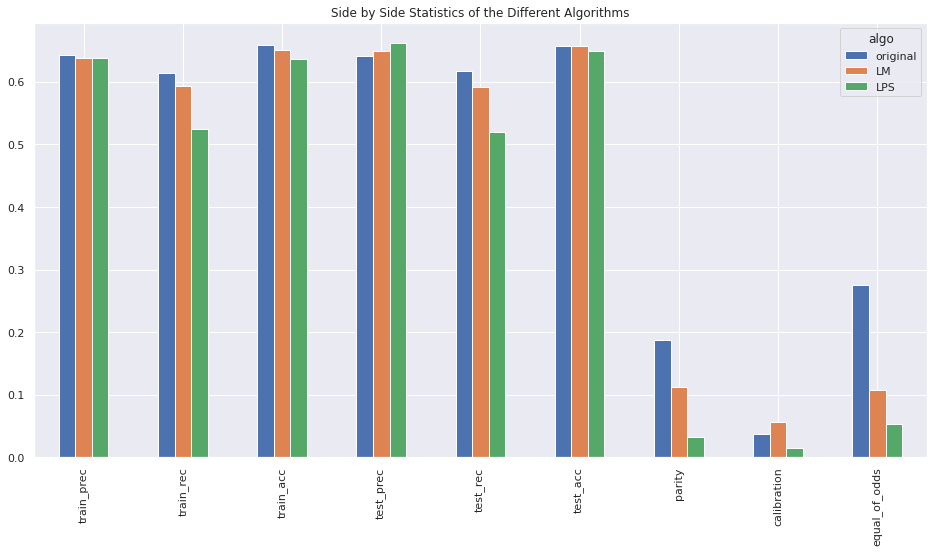

In [44]:
from matplotlib.pyplot import figure
labels = ['train_prec', 'train_rec', 'train_acc', 'test_prec', 'test_rec', 'test_acc', 'parity', 'calibration', 'equal_of_odds']
conc_df = pd.DataFrame(np.array(summary_stats).reshape(3,9), columns=labels)
algo = pd.DataFrame(['original', 'LM', 'LPS'], columns = ['algo'])
conc_df = pd.concat([conc_df, algo], axis=1)
conc_df = conc_df.set_index('algo').T#.rename_axis('Variable')

conc_df.plot(kind='bar', figsize=(16,8), title='Side by Side Statistics of the Different Algorithms')
plt.show()

In [45]:
exp_df = pd.concat([exp_df_Ori, exp_df_LM, exp_df_LPS])
exp_df

,Experiment,Accuracy (mean),Accuracy (std),Black FPR,White FPR
0,Original,0.667614,0.018778,0.396039,0.185077
0,LM,0.660038,0.011253,0.288819,0.272368
0,LPS,0.657765,0.017136,0.254135,0.286929


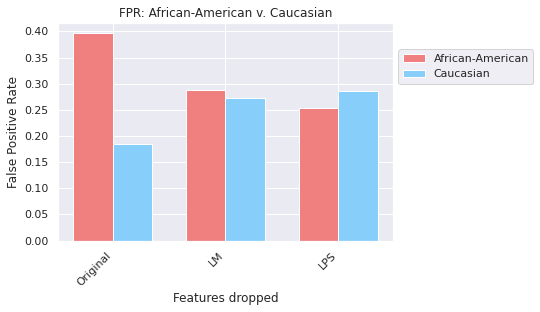

In [46]:
labels = list(exp_df['Experiment'])
x = np.arange(len(exp_df['Experiment']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, exp_df['Black FPR'], width, label='African-American', color='lightcoral')
rects2 = ax.bar(x + width/2, exp_df['White FPR'], width, label='Caucasian', color='lightskyblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('False Positive Rate')
ax.set_xlabel('Features dropped')
ax.set_title('FPR: African-American v. Caucasian')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

#fig.tight_layout()

plt.show()

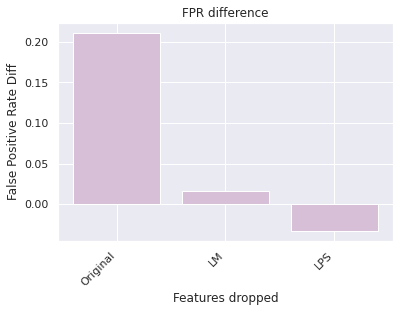

In [47]:
plt.bar(exp_df['Experiment'], exp_df['Black FPR'] - exp_df['White FPR'], color='thistle')
plt.title('FPR difference')
plt.xlabel('Features dropped')
plt.ylabel('False Positive Rate Diff')
plt.xticks(rotation=45, ha="right")
plt.show()